# Create supersites_geom.geojson geojson file with the caucus supersite borders

#### latest run of notebook: 1/28/2024 10am- 
NOTE: need to update precinct to Supersite geojson every time a Supersite/precinct list is modified 
    - e.g. move precincts 814 and 823 from Frasier to Manhatten

## Main Steps
1. create supersites DataFrame from Judi's supersite precinct file
    - INPUT: data/Draft Recap Supersites, Precincts & Chairs 2-6.xlsx (update: 2/6/2024)
    - supersites- DataFrame read from Judi's supersite file
    - OUTPUT: none
2. create pctgeo (precinct GeoDataFrame)
    - INPUT: read precinct geometry from current pct_area_boulder.geojson file
    - add supersite name column using supersites dataframe
    - OUTPUT: data/pct_supersite.geojson (save pctgeo with supersite column) 
    - OUTPUT: data/pct_supersite.xlsx 
3. create ssgeo (supersite border geometry) and save geojson file
    - INPUT: pctgeo GeoDataFrame
    - create ssgeo border_geom
        - from pctgeo by using dissolve('supersite')
    - OUTPUT: data/supersites_region_geom.geojson (save ssgeo)
4. add supersite location information and save file
    - from supersite_venues_all_years.xlsx
        - address
        - website
        - google map link
        - location geometry
    - OUTPUT: supersite_venues.xlsx worksheet=2024
    - OUTPUT: supersite_venues_2024.geojson
5. Create spreadsheet for candidates with Supersites grouped by SD, HD, Area
    - OUTPUT: data/supersite_area_HD_SD_DRAFT_2024_02_06.xlsx



### Notebook History Summary
- full history see git commits
- Started: January 7, 2024
- Update: January 8, 2024 - large revision - add ssname column to supersites
- Update: January 9, 2024 - version 0.1.0 add ssgeom to supersitesgeo
- Update: January 11, 2024 - version 0.2.0 add pctlist column to supersites dataframe
- Update: January 12, 2024 - version 0.3.0 start supersite boundary geometry
- Update: January 13, 2024 - version 0.3.1 finish supersite boundary geometry
- Update: January 19, 2024 - version 0.4.0 add supersite locations
- Update: January 21, 2024 - version 0.4.0 update supersite precincts
- Update: Feb 06, 2024 - version 0.5.0 
    - add section 5 - write supersite_area_HD_SD_DRAFT_2024.xlsx
    - update Judi's recap to "proofing 2-2"


##     ISSUES

#### FIXED Precinct format mismatch
- pct_area_boulder.geojson lists zero-filled precincts, e.g. 002, 003, 004
- Draft Supersites-judi-20240106.xlsx lists single-digit precincts, e.g. 2, 3, 4
    - notebook creates rows for both, 002 and 2, 003 and 3, 004 and 4
    - not critical failure but should be fixed. 
- WORKAROUND: drop extra rows 2, 3, 4
- FIXED: zfill precincts when reading in Judi's file


In [1]:
import pandas as pd
import geopandas as gpd

import supersites as ss
# import fiona
# import numpy as np

## 1. Create supersites - dataframe of supersites with list of precincts in a column  
- start with Judi's spreadsheet
- create pctlist from "Pct #'s" column
    - use pctstr_to_list(ss) function to create series of lists
    - add pctlist series as column on supersites

In [2]:
# check supersites
# - total_precincts matches length of pctlist for each supersites
# - 20 unique supersites in dataframe
# - all columns are 20 non-null


# # supersite_input = 'data/Draft Recap Supersites, Precincts & Chairs .xlsx' # 1/13/2024
# supersite_input = 'data/Draft Recap Supersites, Precincts & Chairs-1-28 .xlsx' # 1/22/2024
# supersite_input = 'data/Draft Recap Supersites, Precincts & Chairs 1-29.xlsx' # 1/31/2024
# sheetname ='Draft 1-29'
supersite_input = 'data/Draft Recap Supersites, Precincts & Chairs 2-6.xlsx' # 1/31/2024
sheetname ='Proofing 2-2'

supersites = ss.read_supersite_pct(supersite_input, sheetname)
supersites.info()
supersites

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   supersite          21 non-null     object
 1   dems               21 non-null     int64 
 2   attendee_forecast  21 non-null     int64 
 3   total_precincts    21 non-null     int64 
 4   pctlist            21 non-null     object
dtypes: int64(3), object(2)
memory usage: 968.0+ bytes


,supersite,dems,attendee_forecast,total_precincts,pctlist
0,Casey MS,8267,207,12,"[810, 817, 818, 820, 821, 822, 823, 824, 825, ..."
1,Centennial MS,8884,222,13,"[803, 804, 805, 806, 807, 811, 812, 813, 814, ..."
2,Horizon K-8,1893,47,3,"[840, 842, 848]"
3,Platt MS,3990,100,9,"[004, 834, 835, 836, 837, 838, 839, 841, 849]"
4,New Vista,3670,92,5,"[828, 829, 831, 832, 833]"
5,Southern Hills MS,9066,227,16,"[830, 843, 844, 845, 846, 847, 850, 851, 852, ..."
6,Erie Elementary,3936,98,9,"[400, 401, 402, 403, 404, 405, 406, 407, 408]"
7,Niwot HS,8719,218,14,"[503, 504, 505, 506, 507, 508, 509, 510, 800, ..."
8,Centaurus HS,11327,283,20,"[300, 301, 302, 303, 304, 305, 306, 307, 308, ..."
9,Altona MS,7518,188,14,"[605, 606, 607, 608, 609, 610, 611, 614, 615, ..."


## 2 create pctgeo (precinct GeoDataFrame)
- read precinct geometry from current pct_area_boulder.geojson file
- add supersite name column using supersites dataframe
- save as pct_supersite.geojson

In [3]:
# 2. Create pctgeo, GeoDataframe from file with individual precinct boundaries
# data/pct_area_boulder.geojson
pctgeo = gpd.read_file('data/pct_area_boulder.geojson', driver='GEOJSON')

# set pctgeo index to Pct
pctgeo = pctgeo.set_index('Pct', drop=False)

pctgeo.info()
pctgeo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 16.1+ KB


,Pct,Precinct,AreaShort,CD,SD,HD,geometry
Pct,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1..."
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9..."
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9..."
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9..."
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9..."


In [4]:
# FUNCTION: Add supersite name column to pctgeo

def add_ss_to_pctgeo(ssdf):

    for ss in ssdf.index:

        # get pctlist in first supersite
        pctlist = ssdf['pctlist'][ss]
        # print(pctlist, '\n')  # list of pcts in supersite

        # get supersite name
        ssname = ssdf.loc[ss,'supersite'] 

        # loop through each pct in pctlist

        for p in pctlist:
            
            # print(p, ssname,'\n')

            # add supersite name to pctgeo
            pctgeo.loc[p, 'supersite'] = ssname
            # print(pctgeo.loc[p, :], '\n')  #  dataframe row
    return



In [5]:
# add supersite column to pctgeo and populate it
pctgeo['supersite'] = ''
add_ss_to_pctgeo(supersites)

pctgeo.info() # check all columns have 193 non-null values
pctgeo.tail(20)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
 7   supersite  193 non-null    object  
dtypes: geometry(1), object(7)
memory usage: 17.6+ KB


,Pct,Precinct,AreaShort,CD,SD,HD,geometry,supersite
Pct,,,,,,,,
855,855,2184907855,BO-01,2,18,49,"POLYGON ((-105.24580 39.98095, -105.24586 39.9...",Southern Hills MS
856,856,2184907856,BO-01,2,18,49,"POLYGON ((-105.24597 39.97645, -105.24597 39.9...",Southern Hills MS
857,857,2184907857,BO-01,2,18,49,"POLYGON ((-105.24748 39.96770, -105.24777 39.9...",Southern Hills MS
900,900,2154907900,BO-01,2,15,49,"MULTIPOLYGON (((-105.16920 39.92870, -105.1689...",Southern Hills MS
901,901,2154907901,MT-01,2,15,49,"POLYGON ((-105.36661 39.97220, -105.37008 39.9...",Nederland HS
902,902,2154907902,MT-01,2,15,49,"POLYGON ((-105.55563 40.01166, -105.55560 40.0...",Nederland HS
903,903,2154907903,MT-01,2,15,49,"POLYGON ((-105.51588 40.02758, -105.51589 40.0...",Nederland HS
904,904,2154907904,MT-01,2,15,49,"POLYGON ((-105.50867 39.97230, -105.50952 39.9...",Nederland HS
905,905,2154907905,MT-01,2,15,49,"POLYGON ((-105.33879 40.00602, -105.34022 40.0...",Nederland HS


In [6]:
# ### Check precinct data in  geodataframe
# - Number of precincts = 193
# - Number of Areas = 27
# - Check precincts in each Area

pctgeo['Pct'].nunique() # 193
pctgeo.AreaShort.nunique() # 27
# pctgeo.value_counts('AreaShort').sort_index()

27

In [7]:
pctgeo.tail(20)

,Pct,Precinct,AreaShort,CD,SD,HD,geometry,supersite
Pct,,,,,,,,
855,855,2184907855,BO-01,2,18,49,"POLYGON ((-105.24580 39.98095, -105.24586 39.9...",Southern Hills MS
856,856,2184907856,BO-01,2,18,49,"POLYGON ((-105.24597 39.97645, -105.24597 39.9...",Southern Hills MS
857,857,2184907857,BO-01,2,18,49,"POLYGON ((-105.24748 39.96770, -105.24777 39.9...",Southern Hills MS
900,900,2154907900,BO-01,2,15,49,"MULTIPOLYGON (((-105.16920 39.92870, -105.1689...",Southern Hills MS
901,901,2154907901,MT-01,2,15,49,"POLYGON ((-105.36661 39.97220, -105.37008 39.9...",Nederland HS
902,902,2154907902,MT-01,2,15,49,"POLYGON ((-105.55563 40.01166, -105.55560 40.0...",Nederland HS
903,903,2154907903,MT-01,2,15,49,"POLYGON ((-105.51588 40.02758, -105.51589 40.0...",Nederland HS
904,904,2154907904,MT-01,2,15,49,"POLYGON ((-105.50867 39.97230, -105.50952 39.9...",Nederland HS
905,905,2154907905,MT-01,2,15,49,"POLYGON ((-105.33879 40.00602, -105.34022 40.0...",Nederland HS


In [8]:
# check # of supersites - expect 20
pctgeo['supersite'].nunique()

# check precincts per supersite
pctgeo['supersite'].value_counts()

supersite
Centaurus HS                20
Longs Peak MS               18
Timberline K-8              17
Southern Hills MS           16
Niwot HS                    14
Altona MS                   14
Louisville MS               13
Centennial MS               13
Casey MS                    12
Platt MS                     9
Erie Elementary              9
Eldorado K8                  8
Burlington Elementary        7
Nederland HS                 6
Lyons Middle Senior          5
New Vista                    5
Horizon K-8                  3
Ward Town Hall               1
Gold Hill School             1
Jamestown School             1
Allenspark Fire Station      1
Name: count, dtype: int64

In [9]:
# save pctgeo with supersite column to file 
pctgeo.to_file('data/pct_supersite.geojson', driver='GeoJSON', index=False)

pctgeo.to_excel('data/pct_supersite.xlsx', index=False)

### 3 Create Supersite GeoDataFrame, ssgeo, and add geometry column 

- create ssgeo by dissolving pctgeo('supersite')
- save ssgeo to supersites_region_geom.geojson

,supersite,geometry
0,Allenspark Fire Station,"POLYGON ((-105.33835 40.25280, -105.33828 40.2..."
1,Altona MS,"POLYGON ((-105.14621 40.12873, -105.14638 40.1..."
2,Burlington Elementary,"POLYGON ((-105.12952 40.13073, -105.12974 40.1..."
3,Casey MS,"POLYGON ((-105.27166 40.01459, -105.27255 40.0..."
4,Centaurus HS,"MULTIPOLYGON (((-105.05283 39.97775, -105.0624..."
5,Centennial MS,"POLYGON ((-105.27269 40.03465, -105.27268 40.0..."
6,Eldorado K8,"POLYGON ((-105.14702 39.92762, -105.14702 39.9..."
7,Erie Elementary,"POLYGON ((-105.05531 40.02197, -105.05532 40.0..."
8,Gold Hill School,"POLYGON ((-105.34886 40.03821, -105.34871 40.0..."
9,Horizon K-8,"POLYGON ((-105.23167 39.99123, -105.23169 39.9..."


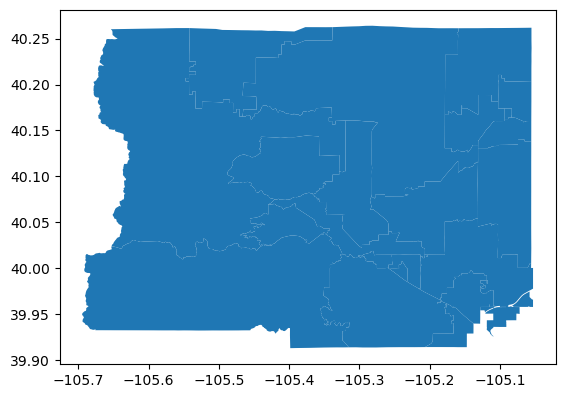

In [10]:
# Create ssgeo: Supersite GeoDataFrame with supersite boundaries
#   pctgeo.dissolve('supersite') 
#      group precincts by supersite 
#      combine group precinct geometry into supersite geometry

ssgeo = pctgeo.dissolve('supersite')
ssgeo = ssgeo.reset_index()
ssgeo = ssgeo[['supersite','geometry']]
ssgeo['supersite'] = ssgeo['supersite'].str.strip()

ssgeo.to_file('data/supersites_region_geom.geojson', driver='GeoJSON')

ssgeo.plot()
ssgeo

### test supersite_region_geom.geojson

In [11]:
supersite_test = gpd.read_file('data/supersites_region_geom.geojson', driver='GeoJSON')
supersite_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   supersite  21 non-null     object  
 1   geometry   21 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 464.0+ bytes


<Axes: >

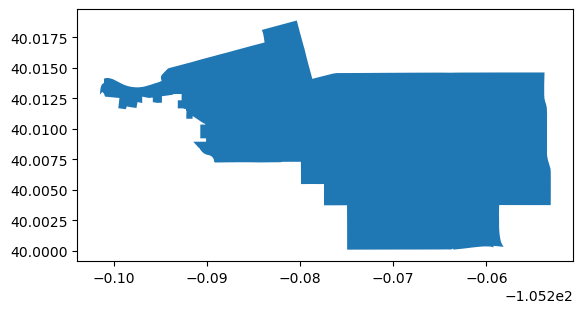

In [12]:
# supersite_test[supersite_test['supersite'] == 'Boulder HS'].plot()
# supersite_test[supersite_test['supersite'] == 'Allenspark Fire Station'].plot()
supersite_test[supersite_test['supersite'] == 'New Vista'].plot()

## 4 ADD LOCATION COLUMN TO 2024 SUPERSITES
- ssgeo GeoDataFrame
    - add location_geom column from supersite_venues_all_years.xlsx
    - copy geometry column to border
    - set_geometry('border') to border

In [13]:
ssgeo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   supersite  21 non-null     object  
 1   geometry   21 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 464.0+ bytes


In [14]:
ssgeo

,supersite,geometry
0,Allenspark Fire Station,"POLYGON ((-105.33835 40.25280, -105.33828 40.2..."
1,Altona MS,"POLYGON ((-105.14621 40.12873, -105.14638 40.1..."
2,Burlington Elementary,"POLYGON ((-105.12952 40.13073, -105.12974 40.1..."
3,Casey MS,"POLYGON ((-105.27166 40.01459, -105.27255 40.0..."
4,Centaurus HS,"MULTIPOLYGON (((-105.05283 39.97775, -105.0624..."
5,Centennial MS,"POLYGON ((-105.27269 40.03465, -105.27268 40.0..."
6,Eldorado K8,"POLYGON ((-105.14702 39.92762, -105.14702 39.9..."
7,Erie Elementary,"POLYGON ((-105.05531 40.02197, -105.05532 40.0..."
8,Gold Hill School,"POLYGON ((-105.34886 40.03821, -105.34871 40.0..."
9,Horizon K-8,"POLYGON ((-105.23167 39.99123, -105.23169 39.9..."


In [15]:
# read in supersite_venues.xlsx
venues = pd.read_excel('data/venues_all_years_fixed.xlsx')

venues.info()
venues

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  33 non-null     float64
 1   venue_id    33 non-null     float64
 2   venue       33 non-null     object 
 3   venue_code  33 non-null     object 
 4   address     33 non-null     object 
 5   org         29 non-null     object 
 6   website     31 non-null     object 
 7   gmap_link   33 non-null     object 
 8   gmap_name   33 non-null     object 
 9   lat         33 non-null     float64
 10  lon         33 non-null     float64
 11  geometry    33 non-null     object 
dtypes: float64(4), object(8)
memory usage: 3.5+ KB


,Unnamed: 0,venue_id,venue,venue_code,address,org,website,gmap_link,gmap_name,lat,lon,geometry
0,0.0,0.0,Allenspark Fire Station,ALLP_FS,"14861 CO-7, Allenspark, CO 80510",NaN,http://www.allensparkfire.com/,https://maps.app.goo.gl/HYN1GYNb9yE4w4RL7,Allenspark Fire Protection,40.197128,-105.527914,POINT (-105.5279141785934 40.19712777610975)
1,1.0,1.0,Altona MS,ALTO_MS,"4600 Clover Basin Dr, Longmont, CO 80503",SVVSD,https://ams.svvsd.org/,https://maps.app.goo.gl/ew5ypnry93DZwFNj8,Altona Middle School,40.144483,-105.162618,POINT (-105.1626179175455 40.14448266991539)
2,2.0,2.0,Angevine MS,ANGV_MS,"1150 W South Boulder Rd, Lafayette, CO 80026",BVSD,http://anm.bvsd.org/,https://maps.app.goo.gl/QtidHUByDwtU8Z599,Angevine Middle School,39.989559,-105.103357,POINT (-105.1033574278846 39.98955883968855)
3,3.0,3.0,Boulder HS,BLDR_HS,"1604 Arapahoe Ave, Boulder, CO 80302",BVSD,http://boh.bvsd.org/,https://maps.app.goo.gl/dKMDjeKUL4kjNDMp6,Boulder High School,40.014116,-105.272871,POINT (-105.2728711769165 40.01411590640171)
4,4.0,4.0,Burlington Elementary,BURL_ES,"1051 S Pratt Pkwy, Longmont, CO 80501",SVVSD,http://bes.svvsd.org/,https://maps.app.goo.gl/QefhqxMskS5oyZY87,Burlington Elementary School,40.146654,-105.108633,POINT (-105.108633248163 40.1466539913149)
5,5.0,5.0,Casey MS,CASE_MS,"1301 High St, Boulder, CO 80304",BVSD,http://cam.bvsd.org/,https://maps.app.goo.gl/kqj3JEma8TPCRKWU9,Casey Middle School,40.022871,-105.279158,POINT (-105.2791579470394 40.0228711759357)
6,6.0,6.0,Centaurus HS,CTAU_HS,"10300 W South Boulder Rd, Lafayette, CO 80026",BVSD,http://ceh.bvsd.org/,https://maps.app.goo.gl/qmDEC4W3XTN7acfs9,Centaurus High School,39.986360,-105.112528,POINT (-105.1125276640655 39.98635981263706)
7,7.0,7.0,Centennial MS,CNTL_MS,"2205 Norwood Ave, Boulder, CO 80304",BVSD,http://cem.bvsd.org/,https://maps.app.goo.gl/tKhhHtoniAvTfpPH9,Centennial Middle School,40.045068,-105.267147,POINT (-105.2671472290834 40.04506796264024)
8,8.0,8.0,Eldorado K8,ELDO_K8,"3351 S Indiana St, Superior, CO 80027",BVSD,http://el8.bvsd.org/,https://maps.app.goo.gl/s2gJjfVYasWGLpMz7,Eldorado K-8 School,39.921698,-105.161197,POINT (-105.161197194222 39.921698179021)
9,9.0,9.0,Eldorado Sp. Fire House,ELSP_FS,"4390 Eldorado Springs Dr, Boulder, CO 80303",NaN,NaN,https://maps.app.goo.gl/TBWeoHAtGKUfwDy79,Rocky Mountain Fire District Station 6,39.942662,-105.249310,POINT (-105.2493101229037 39.94266172014046)


In [16]:
venues['venue'] = venues['venue'].str.strip()

In [17]:
# create GeoDataFrame with location geometry from lon and lat columns
vengdf = gpd.GeoDataFrame(venues, geometry=gpd.points_from_xy(venues['lon'], venues['lat']), crs='EPSG:4326' )

vengdf.info()
# vengdf.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  33 non-null     float64 
 1   venue_id    33 non-null     float64 
 2   venue       33 non-null     object  
 3   venue_code  33 non-null     object  
 4   address     33 non-null     object  
 5   org         29 non-null     object  
 6   website     31 non-null     object  
 7   gmap_link   33 non-null     object  
 8   gmap_name   33 non-null     object  
 9   lat         33 non-null     float64 
 10  lon         33 non-null     float64 
 11  geometry    36 non-null     geometry
dtypes: float64(4), geometry(1), object(7)
memory usage: 3.5+ KB


In [18]:
vengdf.to_excel('data/venues_all_years_fixed.xlsx')

In [19]:
# merge in location information to venues2024
ss2024 = pd.merge(ssgeo, vengdf, left_on='supersite', right_on='venue', how='left')
ss2024 = ss2024.rename(columns={'geometry_x':'border_geom', 'geometry_y': 'location_geom'})
ss2024 = ss2024.set_geometry('location_geom')
# ss2024 = ss2024.drop(columns=['geometry-invalid'])
# ss2024 = ss2024.set_geometry('border_geom')

ss2024 = ss2024.set_crs('EPSG:4326')

ss2024.info()
ss2024

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   supersite      21 non-null     object  
 1   border_geom    21 non-null     geometry
 2   Unnamed: 0     18 non-null     float64 
 3   venue_id       18 non-null     float64 
 4   venue          18 non-null     object  
 5   venue_code     18 non-null     object  
 6   address        18 non-null     object  
 7   org            17 non-null     object  
 8   website        18 non-null     object  
 9   gmap_link      18 non-null     object  
 10  gmap_name      18 non-null     object  
 11  lat            18 non-null     float64 
 12  lon            18 non-null     float64 
 13  location_geom  18 non-null     geometry
dtypes: float64(4), geometry(2), object(8)
memory usage: 2.4+ KB


,supersite,border_geom,Unnamed: 0,venue_id,venue,venue_code,address,org,website,gmap_link,gmap_name,lat,lon,location_geom
0,Allenspark Fire Station,"POLYGON ((-105.33835 40.25280, -105.33828 40.2...",0.0,0.0,Allenspark Fire Station,ALLP_FS,"14861 CO-7, Allenspark, CO 80510",NaN,http://www.allensparkfire.com/,https://maps.app.goo.gl/HYN1GYNb9yE4w4RL7,Allenspark Fire Protection,40.197128,-105.527914,POINT (-105.52791 40.19713)
1,Altona MS,"POLYGON ((-105.14621 40.12873, -105.14638 40.1...",1.0,1.0,Altona MS,ALTO_MS,"4600 Clover Basin Dr, Longmont, CO 80503",SVVSD,https://ams.svvsd.org/,https://maps.app.goo.gl/ew5ypnry93DZwFNj8,Altona Middle School,40.144483,-105.162618,POINT (-105.16262 40.14448)
2,Burlington Elementary,"POLYGON ((-105.12952 40.13073, -105.12974 40.1...",4.0,4.0,Burlington Elementary,BURL_ES,"1051 S Pratt Pkwy, Longmont, CO 80501",SVVSD,http://bes.svvsd.org/,https://maps.app.goo.gl/QefhqxMskS5oyZY87,Burlington Elementary School,40.146654,-105.108633,POINT (-105.10863 40.14665)
3,Casey MS,"POLYGON ((-105.27166 40.01459, -105.27255 40.0...",5.0,5.0,Casey MS,CASE_MS,"1301 High St, Boulder, CO 80304",BVSD,http://cam.bvsd.org/,https://maps.app.goo.gl/kqj3JEma8TPCRKWU9,Casey Middle School,40.022871,-105.279158,POINT (-105.27916 40.02287)
4,Centaurus HS,"MULTIPOLYGON (((-105.05283 39.97775, -105.0624...",6.0,6.0,Centaurus HS,CTAU_HS,"10300 W South Boulder Rd, Lafayette, CO 80026",BVSD,http://ceh.bvsd.org/,https://maps.app.goo.gl/qmDEC4W3XTN7acfs9,Centaurus High School,39.986360,-105.112528,POINT (-105.11253 39.98636)
5,Centennial MS,"POLYGON ((-105.27269 40.03465, -105.27268 40.0...",7.0,7.0,Centennial MS,CNTL_MS,"2205 Norwood Ave, Boulder, CO 80304",BVSD,http://cem.bvsd.org/,https://maps.app.goo.gl/tKhhHtoniAvTfpPH9,Centennial Middle School,40.045068,-105.267147,POINT (-105.26715 40.04507)
6,Eldorado K8,"POLYGON ((-105.14702 39.92762, -105.14702 39.9...",8.0,8.0,Eldorado K8,ELDO_K8,"3351 S Indiana St, Superior, CO 80027",BVSD,http://el8.bvsd.org/,https://maps.app.goo.gl/s2gJjfVYasWGLpMz7,Eldorado K-8 School,39.921698,-105.161197,POINT (-105.16120 39.92170)
7,Erie Elementary,"POLYGON ((-105.05531 40.02197, -105.05532 40.0...",32.0,32.0,Erie Elementary,ERIE_ES,"4137 E County Line Rd, Erie, CO 80516",SVVSD,https://ees.svvsd.org/,https://maps.app.goo.gl/G29aD86nrnjvwdcr5,Erie Elementary School,40.050569,-105.055991,POINT (-105.05599 40.05057)
8,Gold Hill School,"POLYGON ((-105.34886 40.03821, -105.34871 40.0...",12.0,12.0,Gold Hill School,GOLD_ES,"890 Main St, Boulder, CO 80302",BVSD,http://ghe.bvsd.org/,https://maps.app.goo.gl/PZV28vuUvb8p7LJs6,Gold Hill Elementary School,40.063366,-105.412473,POINT (-105.41247 40.06337)
9,Horizon K-8,"POLYGON ((-105.23167 39.99123, -105.23169 39.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


<Axes: >

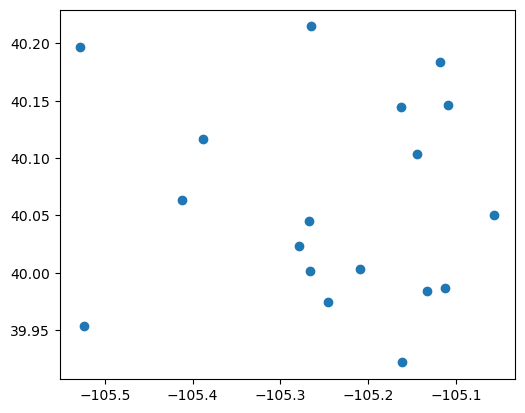

In [20]:
ss2024.plot()

<Axes: >

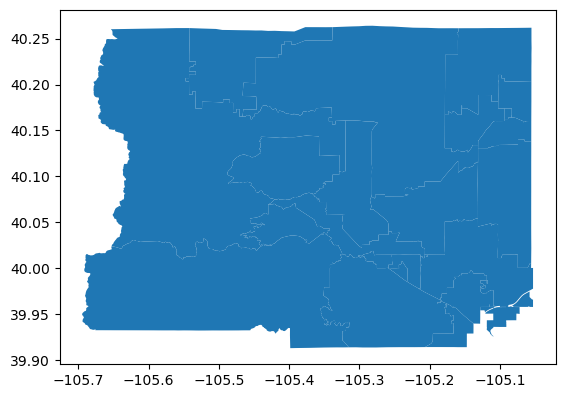

In [21]:
ss2024.set_geometry('border_geom').plot()

In [22]:

ss2024.to_excel('data/supersites_geom_2024.xlsx')

In [23]:
# save supersite locations in geojson file

ss2024.set_geometry('location_geom')
ss2024.drop(columns=['border_geom']).to_file('data/supersites_location_geom_2024.geojson', driver='GeoJSON')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   supersite   21 non-null     object  
 1   Unnamed: 0  18 non-null     float64 
 2   venue_id    18 non-null     float64 
 3   venue       18 non-null     object  
 4   venue_code  18 non-null     object  
 5   address     18 non-null     object  
 6   org         17 non-null     object  
 7   website     18 non-null     object  
 8   gmap_link   18 non-null     object  
 9   gmap_name   18 non-null     object  
 10  lat         18 non-null     float64 
 11  lon         18 non-null     float64 
 12  geometry    18 non-null     geometry
dtypes: float64(4), geometry(1), object(8)
memory usage: 2.3+ KB


<Axes: >

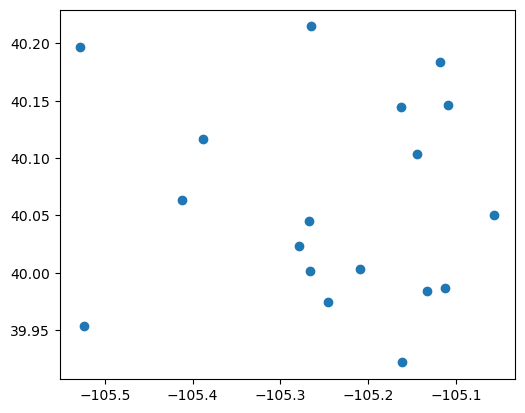

In [24]:
ss2024gdf = gpd.read_file('data/supersites_location_geom_2024.geojson', driver='GeoJSON')

ss2024gdf.info()
ss2024gdf.plot()


## Create spreadsheet with information for candidates and supersite chairs
- For candidates
    - Supersite and precincts grouped by Area, SD, HD

In [25]:
# create pctss dataframe from pctgeo


pctgeo.columns
pctss = pctgeo[['Pct', 'AreaShort', 'SD', 'HD', 'supersite']]

pctss.info()
pctss

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Pct        193 non-null    object
 1   AreaShort  193 non-null    object
 2   SD         193 non-null    object
 3   HD         193 non-null    object
 4   supersite  193 non-null    object
dtypes: object(5)
memory usage: 13.1+ KB


,Pct,AreaShort,SD,HD,supersite
Pct,,,,,
002,002,LM-04,15,19,Timberline K-8
003,003,SU-01,18,49,Eldorado K8
004,004,BO-01,15,12,Platt MS
100,100,SU-01,18,12,Eldorado K8
101,101,SU-01,18,12,Eldorado K8
...,...,...,...,...,...
912,912,MT-02,15,49,Centennial MS
913,913,MT-02,15,49,Jamestown School
914,914,MT-03,15,49,Allenspark Fire Station


In [26]:
# Create ss_areas dataframe that list Areas, CD, SD, HD for each supersite

def collist(s):
    return s.unique().tolist()

ss_areas = pctss.groupby('supersite').agg(
    areas=('AreaShort', collist),
    SDs=('SD', collist),
    HDs=('HD', collist),
    PCTs=('Pct', collist)
)

# convert lists in areas, SDs, HDs, PCTs to strings

ss_areas['area'] = [','.join(map(str, l)) for l in ss_areas['areas']]
ss_areas['sd'] = [','.join(map(str, l)) for l in ss_areas['SDs']]
ss_areas['hd'] = [','.join(map(str, l)) for l in ss_areas['HDs']]
ss_areas['pct'] = [','.join(map(str, l)) for l in ss_areas['PCTs']]

ss_areas = ss_areas[['area', 'sd', 'hd', 'pct']]

ss_areas.info()
ss_areas


<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, Allenspark Fire Station  to Ward Town Hall
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   area    21 non-null     object
 1   sd      21 non-null     object
 2   hd      21 non-null     object
 3   pct     21 non-null     object
dtypes: object(4)
memory usage: 840.0+ bytes


,area,sd,hd,pct
supersite,,,,
Allenspark Fire Station,MT-03,15,49,914
Altona MS,"LM-02,LM-03",17,11,"605,606,607,608,609,610,611,614,615,616,624,62..."
Burlington Elementary,LM-01,17,11,"600,601,602,603,604,612,613"
Casey MS,"BO-08,BO-07,MT-02","18,15","10,49","810,817,818,820,821,822,823,824,825,826,827,910"
Centaurus HS,"LF-01,LF-02","17,18",12,"300,301,302,303,304,305,306,307,308,309,310,31..."
Centennial MS,"BO-10,BO-09,MT-02","18,15","10,49","803,804,805,806,807,811,812,813,814,815,816,91..."
Eldorado K8,SU-01,18,"49,12","003,100,101,102,103,104,105,106"
Erie Elementary,ER-01,17,19,"400,401,402,403,404,405,406,407,408"
Gold Hill School,MT-02,15,49,909


In [27]:
# create dataframe of supersites and precincts in every hd
hd_ss = pctss.groupby('HD').agg(
    supersites=('supersite', collist),
    PCTs=('Pct', collist)
)

hd_ss['supersite'] = [','.join(map(str, l)) for l in hd_ss['supersites']]
hd_ss['pct'] = [','.join(map(str, l)) for l in hd_ss['PCTs']]

hd_ss = hd_ss[['supersite', 'pct']]

hd_ss.info()
hd_ss

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 10 to 49
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   supersite  5 non-null      object
 1   pct        5 non-null      object
dtypes: object(2)
memory usage: 120.0+ bytes


,supersite,pct
HD,,
10,"Niwot HS,Centennial MS,Casey MS,New Vista,Sout...","800,801,802,803,806,807,808,809,810,811,812,81..."
11,"Burlington Elementary,Altona MS,Longs Peak MS,...","600,601,602,603,604,605,606,607,608,609,610,61..."
12,"Platt MS,Eldorado K8,Louisville MS,Centaurus H...","004,100,101,102,103,104,105,106,200,201,202,20..."
19,"Timberline K-8,Erie Elementary","002,400,401,402,403,404,405,406,407,408,619,62..."
49,"Eldorado K8,Lyons Middle Senior,Longs Peak MS,...","003,701,702,704,705,804,805,814,815,827,828,84..."


In [28]:
# create dataframe of supersites and precincts in every sd
sd_ss = pctss.groupby('SD').agg(
    supersites=('supersite', collist),
    PCTs=('Pct', collist)
)

sd_ss['supersite'] = [','.join(map(str, l)) for l in sd_ss['supersites']]
sd_ss['pct'] = [','.join(map(str, l)) for l in sd_ss['PCTs']]

sd_ss = sd_ss[['supersite', 'pct']]

sd_ss.info()
sd_ss

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 15 to 18
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   supersite  3 non-null      object
 1   pct        3 non-null      object
dtypes: object(2)
memory usage: 72.0+ bytes


,supersite,pct
SD,,
15,"Timberline K-8,Platt MS,Lyons Middle Senior,Lo...","002,004,700,701,702,703,704,705,900,901,902,90..."
17,"Centaurus HS,Erie Elementary,Burlington Elemen...","300,301,302,303,304,305,306,307,308,309,310,31..."
18,"Eldorado K8,Louisville MS,Centaurus HS,Niwot H...","003,100,101,102,103,104,105,106,200,201,202,20..."


In [29]:
# write spreadsheet with Supersite information by Area, HD, SD

with pd.ExcelWriter('data/supersite_area_HD_SD_DRAFT_2024_02_06.xlsx') as writer:
    
    ss_areas.to_excel(writer, sheet_name='Areas, SD, HD at Supersite', index=True)
    hd_ss.to_excel(writer, sheet_name="HDs")  
    sd_ss.to_excel(writer, sheet_name="SDs")  